# 参考
- https://qiita.com/0NE_shoT_/items/2b41ae3e8e8f2d8809c4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def generate_sample_data(num, seed=0):
    target_list = [] # 目的変数のリスト
    feature_vector_list = [] # 説明変数（特徴量）のリスト

    feature_num = 8 # 特徴量の数
    intercept = 0.2 # 切片
    weight = [0.2, 0.3, 0.5, -0.4, 0.1, 0.2, 0.5, -0.3] # 各特徴量の重み

    np.random.seed(seed=seed)
    for i in range(num):
        # 一様分布の乱数(0-1)
        feature_vector = [np.random.rand() for n in range(feature_num)] # 特徴量をランダムに生成
        # 正規分布の乱数
        noise = [np.random.normal(0, 0.1) for n in range(feature_num)] # ノイズをランダムに生成
        target = sum([intercept+feature_vector[n]*weight[n]+noise[n] for n in range(feature_num)]) # 目的変数を生成

        target_list.append(target)
        feature_vector_list.append(feature_vector)

    df = pd.DataFrame(np.c_[target_list, feature_vector_list], 
                      columns=['target', 'feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7'])
    return df

In [7]:
data = generate_sample_data(num=1000, seed=0)

In [8]:
data.head()

,target,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7
0,2.487149,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.437587,0.891773
1,1.771773,0.978618,0.799159,0.461479,0.780529,0.118274,0.639921,0.143353,0.944669
2,2.512648,0.612096,0.616934,0.943748,0.681820,0.359508,0.437032,0.697631,0.060225
3,2.000913,0.988374,0.102045,0.208877,0.161310,0.653108,0.253292,0.466311,0.244426
4,1.802101,0.739264,0.039188,0.282807,0.120197,0.296140,0.118728,0.317983,0.414263


In [24]:
len(data)

1000

In [9]:
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# PyStan による実装

In [10]:
#!pip install arviz

In [11]:
import pystan
import arviz

In [17]:
sample_code = """
    data {
        int<lower=0> N;
        int<lower=0> D;
        matrix[N, D] X;
        vector[N] y;
        int<lower=0> N_new;
        matrix[N_new, D] X_new;
    }
    parameters {
        real w0;
        vector[D] w;
        real<lower=0> sigma;
    }
    model {
        for (i in 1:N)
            y[i] ~ normal(w0 + dot_product(X[i], w), sigma);
    }
    generated quantities {
        vector[N_new] y_new;
        for (i in 1:N_new)
            y_new[i] = normal_rng(w0 + dot_product(X_new[i], w), sigma);
    }
"""

In [18]:
sample_data = {
    'N': X_train.shape[0],
    'D': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_new': X_test.shape[0],
    'X_new': X_test
}

In [19]:
sm = pystan.StanModel(model_code=sample_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_92cd13fa4b6e158fdf4f4ede934e6196 NOW.


In [20]:
fit = sm.sampling(data=sample_data, iter=1000, chains=4)
print(fit)

Inference for Stan model: anon_model_92cd13fa4b6e158fdf4f4ede934e6196.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w0           1.61  1.3e-3   0.05   1.51   1.57   1.61   1.64   1.71   1608    1.0
w[1]         0.19  6.9e-4   0.03   0.12   0.16   0.19   0.21   0.26   2501    1.0
w[2]         0.35  6.4e-4   0.03   0.28   0.33   0.35   0.37   0.41   2672    1.0
w[3]          0.5  6.3e-4   0.03   0.43   0.48    0.5   0.52   0.56   2451    1.0
w[4]        -0.41  7.3e-4   0.04  -0.48  -0.44  -0.41  -0.39  -0.34   2396    1.0
w[5]         0.08  6.7e-4   0.03   0.01   0.06   0.08   0.11   0.15   2599    1.0
w[6]         0.21  7.2e-4   0.03   0.14   0.19   0.21   0.24   0.28   2317    1.0
w[7]         0.47  6.9e-4   0.03    0.4   0.45   0.47   0.49   0.54   2577    1.0
w[8]        -0.33  6.6e-4   0.03  -0.39  -0.35  -0.33   -0.3  -0.26   2610 

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (210), generating only 20 plots
  UserWarning,


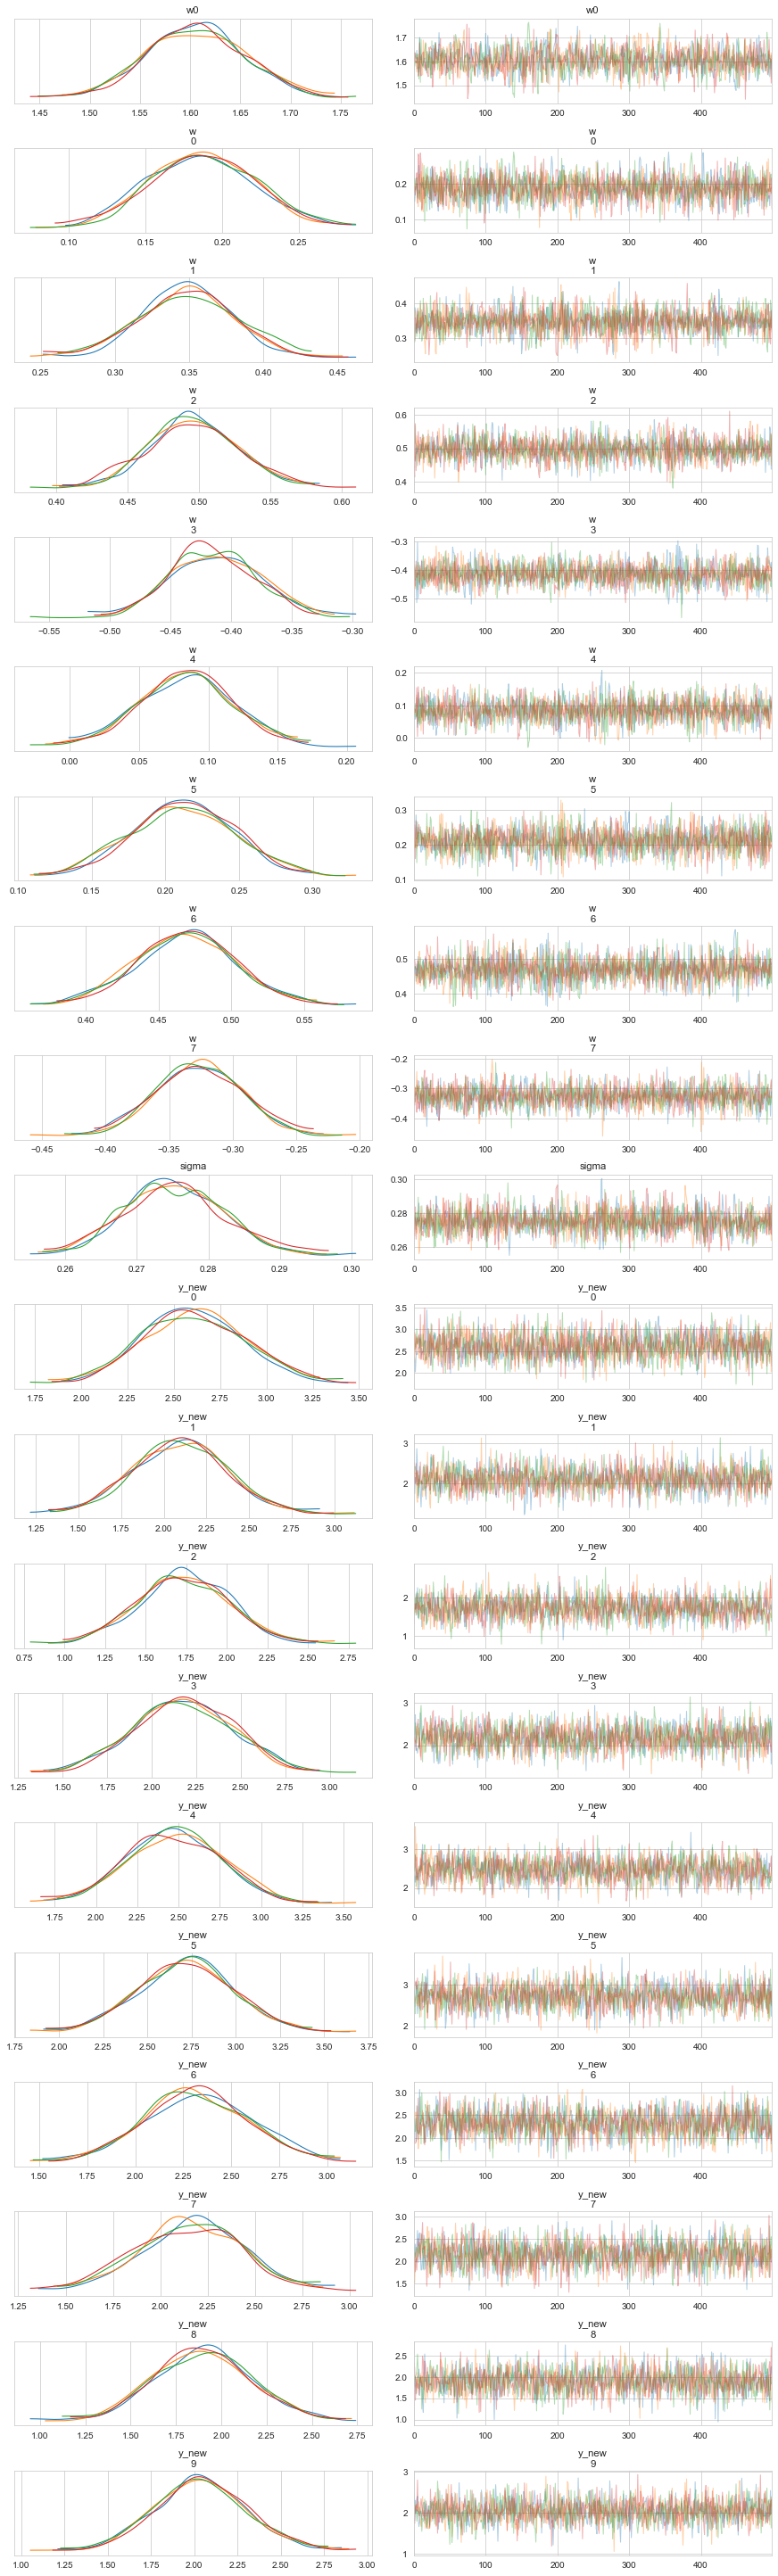

In [25]:
arviz.plot_trace(fit)
plt.show()

In [26]:
y_pred = fit['y_new'].mean(axis=0)
print('MSE(test) = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('R^2(test) = {:.2f}'.format(r2_score(y_test, y_pred)))

MSE(test) = 0.07
R^2(test) = 0.50


In [12]:
from sklearn.datasets import load_boston

In [13]:
boston = load_boston()

In [23]:
pd.DataFrame(boston.data, columns=boston.feature_names)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [21]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')